In [1]:
#start imports
import os
from PIL import Image,ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import math
import json
import pandas as pd
from skimage.measure import regionprops_table, label
from skimage.morphology import remove_small_objects, remove_small_holes
from scipy.ndimage import binary_fill_holes
from scipy.optimize import curve_fit


fileDir = "salm_plate_images/extracted_cropped_images/" #enter the file directory of the images you want processed here
fileNameArray = sorted(os.listdir(fileDir)) #creates an array of the file names here

Converts your images into arrays and stores them in imgarrList

In [2]:
#creates a list of arrays of all of your images
#at every x,y position, has three values that correspond to RGB values from 0-255
finalImageList={}
for filename in fileNameArray:
    tempImg = Image.open(fileDir +filename)
    finalImageList[filename]= np.array(tempImg)

#testing_im = Image.fromarray(finalImageList['tween_0_0.png'], 'RGB')
#testing_im

In [3]:
#function which will calculate the area of an image array
def calculateArea(imgarr, threshold):
    gray_image = ski.color.rgb2gray(imgarr)
    t = threshold
    binary_mask = gray_image > t
    label_image = label(binary_mask > 0)
    props = regionprops_table(label_image, properties=['label', 'area'])
    #pixelArea = np.sum(binary_mask)
    areas = np.array(np.array(props['area']) * ((90/1040)**2))
    three_areas = np.sort(areas)[-3:]
    return three_areas #pixelArea * ((90/1040)**2)

Creating histogram for determination of thresholding

In [4]:
#creating the images back from array, into an image format
processedImgList = {}
for x in finalImageList.keys():
    processedImgList[x]=Image.fromarray(finalImageList[x], 'RGB')

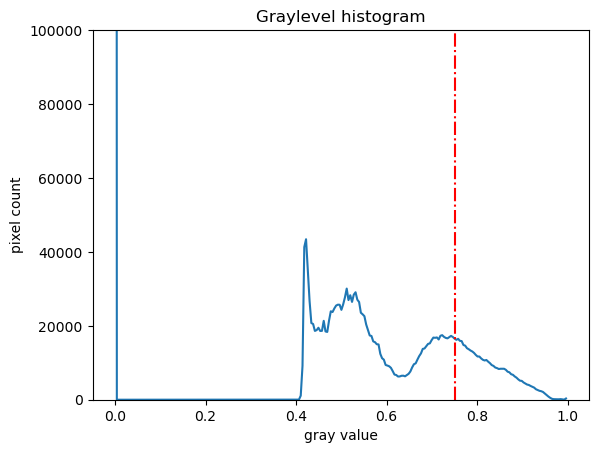

In [5]:
#determination of the optimal threshopld for segmentation
#different values for E. coli and Salmonella
thresholdValue = 0.75
gray_image = ski.color.rgb2gray(processedImgList[fileNameArray[1]])
histogram, bin_edges = np.histogram(gray_image, bins=256, range=(0.0, 1.0))
fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Graylevel histogram")
plt.xlabel("gray value")
plt.ylabel("pixel count")
plt.ylim(0,1e5)
plt.axvline(thresholdValue, linestyle= '-.', color='r')
plt.show()

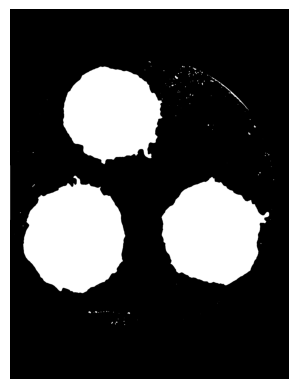

In [6]:
#remake images
thresholdValue = 0.7
for choiceNum in range(len(finalImageList.keys())):
    newgray=ski.color.rgb2gray(processedImgList[fileNameArray[choiceNum]])
    mask = newgray>thresholdValue

    label_image = label(mask == 0)
    props = regionprops_table(label_image, properties=['label', 'area'])

    # Find the largest black region
    largest_label = props['label'][np.argmax(props['area'])]  # Label of the largest black region

    # Create a mask where only the largest black region remains black
    largest_black_region = label_image == largest_label

    # Set everything else to white
    final_image = ~largest_black_region
    processedImgList[fileNameArray[choiceNum]] = final_image

plt.imshow(processedImgList[fileNameArray[1]], 'gray')
plt.axis('off')
plt.show()

In [ ]:
#now applying the area calculator
testingArea = {}
count=0
scaling_factors = [1890, 1950, 2050, 2130, 1950, 2160, 1910, 2100, 2060, 2020, 2130] #number of pixels per 80mm for each image
for x in processedImgList.keys():
    label_image = label(processedImgList[x] > 0)
    props = regionprops_table(label_image, properties=['label', 'area'])
    #pixelArea = np.sum(binary_mask)
    areas = np.array(np.array(props['area']) * ((80/scaling_factors[count])**2))
    three_areas = np.sort(areas)[-3:] #takes the three largest areas
    testingArea[x] =three_areas
    count+=1

In [ ]:
#saves the results to a text file
if True:
    with open("salm_plate_results/salm_tween.txt", 'w') as file:
        for x in testingArea.keys():
            file.write(x+" ")
            file.write(str(testingArea[x]) + str("\n"))

In [9]:
salm_surface_tension_values = pd.read_csv("salm_plate_results/salm-tween-dependency.csv", usecols=['Tween Concentrations', 'Surface Tensions'], nrows=11)
salm_surface_tension_values

,Tween Concentrations,Surface Tensions
0,0.000000,72.000000
1,-6.397940,63.287588
2,-6.096910,58.181895
3,-5.920819,54.651168
4,-5.823909,52.640283
5,-5.721246,50.524509
6,-5.638272,48.862856
7,-5.568636,47.522718
8,-5.508638,46.418681
9,-5.468521,45.710254


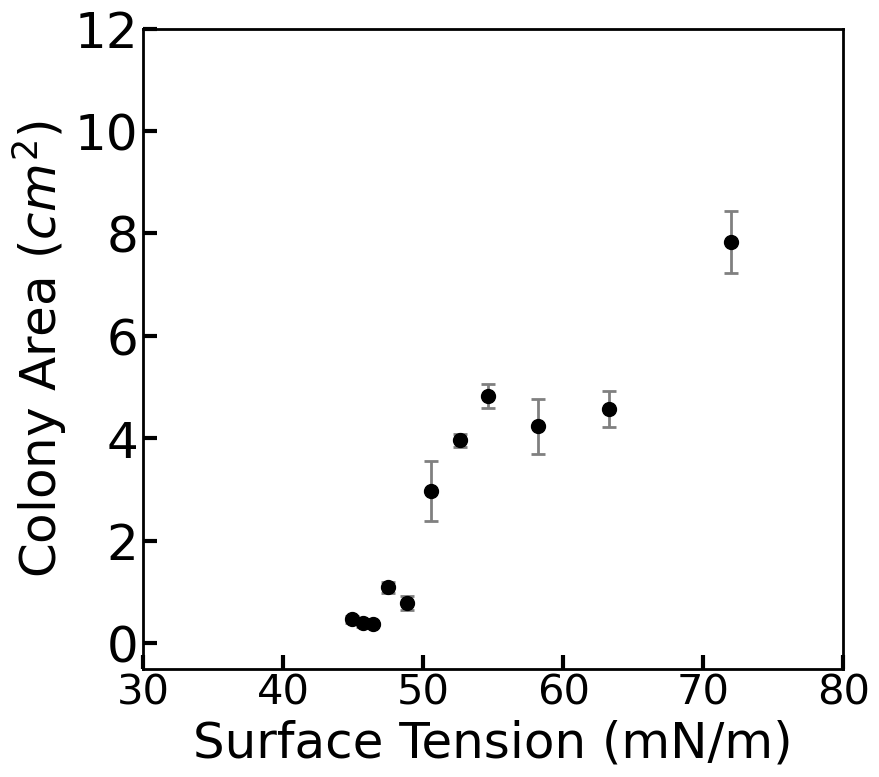

In [10]:
# load the data
averages = [np.average(testingArea[key]) for key in testingArea.keys()]
errors = [np.std(testingArea[key]) for key in testingArea.keys()]
x_axis = salm_surface_tension_values['Surface Tensions']

fig = plt.figure(figsize=(14,8))
ax = plt.axes((0.1,0.1,0.5,0.8))

'''ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')'''
ax.tick_params(axis='x', direction='in', labelsize=30, width=3, length=10)
ax.tick_params(axis='y', direction='in', labelsize=30, width=3, length=10)

ax.errorbar(x_axis, np.array(averages)/100, yerr=np.array(errors)/100, fmt='o', color='black', ecolor='grey', markersize=10, capsize=5, capthick=2, elinewidth=2)

plt.yticks(fontsize=36)

ax.set_ylim(-0.5, 12)
ax.set_xlim(30, 80)
ax.set_ylabel(r"Colony Area ($cm^{2}$)", fontsize=36)
ax.set_xlabel("Surface Tension (mN/m)", fontsize=36)
ax.spines['bottom'].set_linewidth(2)  # Make the x-axis line thicker
ax.spines['left'].set_linewidth(2)    # Make the y-axis line thicker
ax.spines['top'].set_linewidth(2)  # Make the x-axis line thicker
ax.spines['right'].set_linewidth(2)    # Make the y-axis line thicker
plt.savefig("salm_plate_results/areas_plot.svg", dpi=300, bbox_inches='tight')
plt.show()